In [1]:
import numpy as np
import pandas as pd
import pymatgen as mg
import itertools
import time
import seaborn as sn
import sys

# imports from perovskite_ml (not yet set up for installation)
if '../perovskite_ml' not in sys.path:
    sys.path.append('../perovskite_ml')
from calc_chemfeat import Perovskite
from featurizers import PerovskiteProperty
from feature_select import get_linked_groups

%load_ext autoreload
%autoreload 2

Created MatProjCalc instance
loaded featurizers


# Base Perovskite class

## Instantiation

The Perovskite class can be initialized manually by specifying chemical formula, cation site assignments, oxidation state limits for each site, and base oxidation state for each site. The class also accepts optional parameters to specify the radius type used in feature calculations (crystal or ionic), whether to normalize the chemical formula, and whether to print informational messages.

In [2]:
p = Perovskite('BaCo0.5Zr0.4Y0.1O3',
               cation_site={'Ba':'A','Co':'B','Zr':'B','Y':'B'},
               site_ox_lim={'A':[2,2],'B':[2,4]},
               site_base_ox={'A':2,'B':4,'X':-2},
               radius_type='ionic_radius',
               normalize_formula=True,
               silent=False
              )

The class can also instantiated using the `from_preset` method, which allows required parameters to be loaded quickly from a known preset. Currently, there is only a preset for Ba(Co,Fe,Zr,Y)O$_3$ (BCFZY).

In [22]:
p = Perovskite.from_preset('BaCo0.4Fe0.4Zr0.1Y0.1O3',preset_name='BCFZY',silent=False)

## Attributes

The instance splits the full composition into separate A, B and X site compositions. This allows for discrete featurization of each site.

In [23]:
p.site_composition

{'A': Comp: Ba1,
 'B': Comp: Y0.1 Zr0.1 Fe0.4 Co0.4,
 'X': Comp: O3,
 'comp': Comp: Ba1 Y0.1 Zr0.1 Fe0.4 Co0.4 O3}

The class is oriented toward complex perovskites with cation doping at the A and/or B sites. It determines the possible elemental oxidation states for each ion based on common oxidation states and user-specified site limits.

In [24]:
p.allowed_ox_states

{'Ba': (2,),
 'Co': (2, 3, 4),
 'Fe': (2, 3, 4),
 'Zr': (4,),
 'Y': (3,),
 'O': (-2,)}

Oxidation state limits can also be set for individual ions in addition to the site limitations.

In [25]:
p.set_ion_ox_lim('Co',[2,3])
p.set_ion_ox_lim('Fe',[3,4])
p.allowed_ox_states

{'Ba': (2,), 'Co': (2, 3), 'Fe': (3, 4), 'Zr': (4,), 'Y': (3,), 'O': (-2,)}

An important feature of the class is its consideration of all possible oxidation states of each cation, and all combinations thereof. This is reflected in the generation of oxidation-state-dependent properties. Each row of the resulting dataframes shown below represents one combination of oxidation states. These rows are later aggregated to generate features.

In [27]:
"Generate oxidation-state-dependent properties for the full composition (ABX3)"
p.set_comp_ox_features()
p.comp_ox_features

Created MatProjCalc instance
Full composition oxidation state combinations
Fixed valence: Ba 2 ['XII']
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Fixed valence: O -2 ['II']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]
A-site oxidation state combinations
Fixed valence: Ba 2 ['XII']
B-site oxidation state combinations
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]
X-site oxidation state combinations
Fixed valence: O -2 ['II']


,goldschmidt,goldschmidt_struct,tau,tot_cat_charge,anion_delta,alat_hardsphere,uc_vol,uc_vol_free,r_crit,r_AB_ratio
Ba2_Zr4_Y3_O-2_Co2_Fe3,1.012106,3.0,3.133381,4.7,0.65,4.186072,73.353379,30.819683,0.744640,2.039627
Ba2_Zr4_Y3_O-2_Co2_Fe4,1.023990,3.0,3.113273,5.1,0.45,4.186072,73.353379,29.551413,0.753119,2.098321
Ba2_Zr4_Y3_O-2_Co3_Fe3,1.039243,3.0,3.102033,5.1,0.45,4.186072,73.353379,29.804312,0.763778,2.176617
Ba2_Zr4_Y3_O-2_Co3_Fe4,1.051777,3.0,3.104192,5.5,0.25,4.186072,73.353379,28.509365,0.772354,2.243590


In [29]:
"Generate oxidation-state-dependent properties for the B site"
p.set_site_ox_features('B')
p.site_ox_features['B']

B-site oxidation state combinations
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]


,r_mean,r_std,OS_mean,OS_std,tot_charge,X_cat_mean,X_cat_std,ion_energy_mean,ion_energy_std
Zr4_Y3_Co2_Fe3,0.858,0.075736,2.7,0.640312,2.7,3.786958,1.200770,4196030.0,1.679738e+06
Zr4_Y3_Co2_Fe4,0.834,0.100519,3.1,0.943398,3.1,4.883613,2.370159,6312030.0,3.759121e+06
Zr4_Y3_Co3_Fe3,0.804,0.084817,3.1,0.300000,3.1,4.898874,0.743962,5488830.0,8.404888e+05
Zr4_Y3_Co3_Fe4,0.780,0.094710,3.5,0.500000,3.5,5.995528,1.513444,7604830.0,2.558273e+06


Oxidation-state-dependent properties derived from thermodynamic data, such as the average M-X bond energy, are calculated separately in order to consider non-integer mean oxidation states (e.g. Co has a mean OS of 8/3 in Co3O4). Experimental thermodynamic data is retrieved via the Materials Project API.

In [30]:
"Generate possible site-averaged M-X bond energies for B site"
p.set_site_oxcombo_MX_ABE('B')
p.site_MX_ABE

Formation enthalpy for CoO in solid phase includes exp data from phases: cubic, solid
Formation enthalpy for Co in gas phase includes exp data from phases: gas
Formation enthalpy for Co3O4 in solid phase includes exp data from phases: cubic, solid
Formation enthalpy for Co in gas phase includes exp data from phases: gas
Formation enthalpy for Fe2O3 in solid phase includes exp data from phases: hemat, solid
Formation enthalpy for Fe in gas phase includes exp data from phases: gas
Formation enthalpy for ZrO2 in solid phase includes exp data from phases: monocl
Formation enthalpy for Zr in gas phase includes exp data from phases: gas
Formation enthalpy for Y2O3 in solid phase includes exp data from phases: cubic
Formation enthalpy for Y in gas phase includes exp data from phases: gas


{'B': {2.7: -1241.099, 2.966666666666667: -1300.5683333333334}}

## Features

Calling the `featurize` method will featurize the composition. The user may specify which sites should be featurized; composition-level oxidation-state-dependent features are always calculated. Including 'comp' in the list of sites will cause composition-level oxidation-state-independent features to be generated. Including individual sites ('A', 'B', and/or 'X') will cause all features to be calculated for each site specified; otherwise, no site-level features will be calculated.

The user may also specify how oxidation-state-dependent properties should be aggregated in the `ox_stats` arg. This takes a list of aggregate functions. Any built-in Pandas aggregate function is accepted, as well as 'range'.

The number of features returned, and the corresponding labels, depend on which sites are featurized and how oxidation-state-dependent features are aggregated.

In [31]:
"featurize all sites and use all aggregate functions"
p.featurize(sites=['A','B','X','comp'],ox_stats=['min','max','mean','median','std','range'])

A-site oxidation state combinations
Fixed valence: Ba 2 ['XII']
B-site oxidation state combinations
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]
X-site oxidation state combinations
Fixed valence: O -2 ['II']
Full composition oxidation state combinations
Fixed valence: Ba 2 ['XII']
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Fixed valence: O -2 ['II']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]
Full composition oxidation state combinations
Fixed valence: Ba 2 ['XII']
Fixed valence: Zr 4 ['VI']
Fixed valence: Y 3 ['VI']
Fixed valence: O -2 ['II']
Multivalent: Co ["2 ['VI']", "3 ['VI']"]
Multivalent: Fe ["3 ['VI']", "4 ['VI']"]
Formation enthalpy for BaO in solid phase includes exp data from phases: cubic, solid
Formation enthalpy for Ba in gas phase includes exp data from phases: gas
Formation enthalpy for CoO in solid phase includes exp data from phase

comp_oxmin_goldschmidt            1.012106
comp_oxmin_goldschmidt_struct     3.000000
comp_oxmin_tau                    3.102033
comp_oxmin_tot_cat_charge         4.700000
comp_oxmin_anion_delta            0.250000
                                   ...    
comp_acceptor_mag                -0.020000
comp_donor_mag                    0.000000
comp_mass_mean                   49.849893
comp_mass_std                    47.876736
AB_ratio                          1.000000
Length: 321, dtype: float64

In [32]:
p.feature_labels(sites=['A','B','X','comp'],ox_stats=['min','max','mean','median','std','range'])

['comp_oxmin_goldschmidt',
 'comp_oxmin_goldschmidt_struct',
 'comp_oxmin_tau',
 'comp_oxmin_tot_cat_charge',
 'comp_oxmin_anion_delta',
 'comp_oxmin_alat_hardsphere',
 'comp_oxmin_uc_vol',
 'comp_oxmin_uc_vol_free',
 'comp_oxmin_r_crit',
 'comp_oxmin_r_AB_ratio',
 'comp_oxmax_goldschmidt',
 'comp_oxmax_goldschmidt_struct',
 'comp_oxmax_tau',
 'comp_oxmax_tot_cat_charge',
 'comp_oxmax_anion_delta',
 'comp_oxmax_alat_hardsphere',
 'comp_oxmax_uc_vol',
 'comp_oxmax_uc_vol_free',
 'comp_oxmax_r_crit',
 'comp_oxmax_r_AB_ratio',
 'comp_oxmean_goldschmidt',
 'comp_oxmean_goldschmidt_struct',
 'comp_oxmean_tau',
 'comp_oxmean_tot_cat_charge',
 'comp_oxmean_anion_delta',
 'comp_oxmean_alat_hardsphere',
 'comp_oxmean_uc_vol',
 'comp_oxmean_uc_vol_free',
 'comp_oxmean_r_crit',
 'comp_oxmean_r_AB_ratio',
 'comp_oxmedian_goldschmidt',
 'comp_oxmedian_goldschmidt_struct',
 'comp_oxmedian_tau',
 'comp_oxmedian_tot_cat_charge',
 'comp_oxmedian_anion_delta',
 'comp_oxmedian_alat_hardsphere',
 'comp_ox

# PerovskiteProperty featurizer

The `PerovskiteProperty` class is a subclass of the matminer `BaseFeaturizer` class. It uses the `Perovskite` class to generate a base set of features, and utilizes several matminer featurizers to append additional features. `PerovskiteProperty` inherits useful methods from `BaseFeaturizer`, namely `featurize_many` and `featurize_dataframe`, which enable parallel processing for featurizing large datasets.

Whereas an instance of `Perovskite` represents a single composition, an instance of `PerovskiteProperty` is not tied to a specific composition and can be used to featurize any number of compositions. The class is istantiated with several of the same parameters as `Perovskite`, and requires that featurize options be set before featurizing:

In [3]:
"manual instantiation"
pp = PerovskiteProperty(cation_site={'Ba':'A','Co':'B','Fe':'B','Zr':'B','Y':'B'},
                        site_ox_lim={'A':[2,2],'B':[2,4],'X':[-2,-2]},
                        site_base_ox={'A':2,'B':4,'X':-2})
"from preset"
pp = PerovskiteProperty.from_preset('BCFZY')

"set the featurization options"
pp.set_featurize_options(sites=['B','comp'],ox_stats=['mean','median','std'],ep_stats=['mean','std_dev'],silent=False)

`PerovskiteProperty` adds a number of features from several existing matminer featurizers: `ValenceOrbital`, `AtomicOrbitals`, `CohesiveEnergy`, and `ElementProperty`. These featurizers can be applied to each perovskite site separately, as in the `Perovskite` class.

In [4]:
pp.matminer_labels

['valence_elec_s_mean',
 'valence_elec_p_mean',
 'valence_elec_d_mean',
 'valence_elec_f_mean',
 'valence_elec_s_frac',
 'valence_elec_p_frac',
 'valence_elec_d_frac',
 'valence_elec_f_frac',
 'valence_elec_tot_mean',
 'HOMO_energy',
 'LUMO_energy',
 'AO_gap',
 'cohesive_energy_mean',
 'boil_temp_mean',
 'boil_temp_std',
 'melt_temp_mean',
 'melt_temp_std',
 'bulk_mod_mean',
 'bulk_mod_std',
 'shear_mod_mean',
 'shear_mod_std',
 'row_mean',
 'row_std',
 'column_mean',
 'column_std',
 'number_mean',
 'number_std',
 'mendeleev_mean',
 'mendeleev_std',
 'space_group_mean',
 'space_group_std',
 'density_mean',
 'density_std',
 'molar_vol_mean',
 'molar_vol_std',
 'H_fus_mean',
 'H_fus_std',
 'H_vap_mean',
 'H_vap_std',
 'valence_unfilled_s_mean',
 'valence_unfilled_s_std',
 'valence_unfilled_p_mean',
 'valence_unfilled_p_std',
 'valence_unfilled_d_mean',
 'valence_unfilled_d_std',
 'valence_unfilled_f_mean',
 'valence_unfilled_f_std',
 'polarizability_mean',
 'polarizability_std',
 'sigma_

The `featurize` method takes a Pymatgen Composition object as input, rather than a chemical formula string:

In [5]:
comp = mg.Composition('BaCo0.4Fe0.4Zr0.1Y0.1O3')
pp.featurize(comp)

A-site oxidation state combinations
Fixed valence: Ba 2 ['XII']
B-site oxidation state combinations
Fixed valence: Y 3 ['VI']
Fixed valence: Zr 4 ['VI']
Multivalent: Fe ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
Multivalent: Co ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
X-site oxidation state combinations
Fixed valence: O -2 ['II']
Full composition oxidation state combinations
Fixed valence: Ba 2 ['XII']
Fixed valence: Y 3 ['VI']
Fixed valence: Zr 4 ['VI']
Fixed valence: O -2 ['II']
Multivalent: Fe ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
Multivalent: Co ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
Full composition oxidation state combinations
Fixed valence: Ba 2 ['XII']
Fixed valence: Y 3 ['VI']
Fixed valence: Zr 4 ['VI']
Fixed valence: O -2 ['II']
Multivalent: Fe ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
Multivalent: Co ["2 ['VI']", "3 ['VI']", "4 ['VI']"]
Formation enthalpy for BaO in solid phase includes exp data from phases: cubic, solid
Formation enthalpy for Ba in gas phase includes exp data from phases: ga

[1.0309529266831876,
 2.888888888888889,
 3.5038875956548696,
 5.1,
 0.4499999999999999,
 4.192508572999433,
 73.69644378016149,
 28.590293181932736,
 0.9010567192556747,
 2.374757095650333,
 1.0280137879725837,
 3.0,
 3.4699959770976587,
 5.1000000000000005,
 0.44999999999999973,
 4.1860721446243625,
 73.35337940468168,
 28.23983199496695,
 0.8959546858908346,
 2.346938775510204,
 0.025818407106489694,
 0.3333333333333334,
 0.08179193917206917,
 0.4898979485566357,
 0.24494897427831785,
 0.019309285125212725,
 1.0291931264394523,
 2.958849348839554,
 0.01373605909791713,
 0.1765541163171362,
 0.6813333333333333,
 0.0951561222733619,
 3.1000000000000005,
 0.6008592775156861,
 3.1000000000000005,
 7.554290782710414,
 2.799545795123758,
 6028963.333333333,
 2313986.938723427,
 0.6860000000000002,
 0.0975499871860576,
 3.1000000000000005,
 0.6403124237432849,
 3.1000000000000005,
 7.2586385497821695,
 2.492072859895934,
 6286030.0,
 2155508.9515239783,
 0.05112729212465684,
 0.02457084538

`featurize_dataframe` allows for convenient featurization of many compositions. For smaller jobs, parallelization may not be efficient. This can be turned off by callling `pp.set_n_jobs(1)`.

In [6]:
"Generate compositions"
amts = np.arange(0,1.01,0.1)
comps = [[mg.Composition('BaCo{}Fe{}Zr{}Y{}O3'.format(a,b,c,round(1-a-b-c,1)))] for a,b,c in itertools.product(amts,amts,amts) if a + b + c <= 1]
df = pd.DataFrame(comps,columns=['composition'])
df.head()

,composition
0,"(Ba, Y, O)"
1,"(Ba, Zr, Y, O)"
2,"(Ba, Zr, Y, O)"
3,"(Ba, Zr, Y, O)"
4,"(Ba, Zr, Y, O)"


In [7]:
#set to silent
pp.set_featurize_options(sites=['B','comp'],ox_stats=['mean','median','std'],ep_stats=['mean','std_dev'],silent=True)

start = time.time()
feat_df = pp.featurize_dataframe(df,col_id="composition",inplace=False)
elapsed = time.time() - start
print('Featurized {} compositions in {} s. Time per record: {} s'.format(len(df),round(elapsed,1),round(elapsed/len(df),2)))


Featurized 282 compositions in 34.1 s. Time per record: 0.12 s


In [8]:
feat_df.head()

,composition,comp_oxmean_goldschmidt,comp_oxmean_goldschmidt_struct,comp_oxmean_tau,comp_oxmean_tot_cat_charge,comp_oxmean_anion_delta,comp_oxmean_alat_hardsphere,comp_oxmean_uc_vol,comp_oxmean_uc_vol_free,comp_oxmean_r_crit,...,comp_valence_unfilled_p_mean,comp_valence_unfilled_p_std,comp_valence_unfilled_d_mean,comp_valence_unfilled_d_std,comp_valence_unfilled_f_mean,comp_valence_unfilled_f_std,comp_polarizability_mean,comp_polarizability_std,comp_sigma_therm_mean,comp_sigma_therm_std
0,"(Ba, Y, O)",0.930238,2.0,3.651669,5.0,0.50,4.500,91.125000,44.825387,0.986366,...,1.2,1.309307,1.80,4.810702,0.0,0.0,12.9612,21.157117,7.015948,11.446841
1,"(Ba, Zr, Y, O)",0.937740,2.0,3.597095,5.1,0.45,4.464,88.955449,42.320114,0.973502,...,1.2,1.300971,1.78,4.730315,0.0,0.0,12.8652,20.962849,7.135948,11.611867
2,"(Ba, Zr, Y, O)",0.945364,2.0,3.550212,5.2,0.40,4.428,86.820611,39.842371,0.960687,...,1.2,1.294596,1.76,4.656947,0.0,0.0,12.7692,20.799919,7.255948,11.784823
3,"(Ba, Zr, Y, O)",0.953113,2.0,3.510777,5.3,0.35,4.392,84.720204,37.392025,0.947920,...,1.2,1.290099,1.74,4.590060,0.0,0.0,12.6732,20.666727,7.375948,11.966479
4,"(Ba, Zr, Y, O)",0.960990,2.0,3.478596,5.4,0.30,4.356,82.653950,34.968942,0.935202,...,1.2,1.287423,1.72,4.529218,0.0,0.0,12.5772,20.562093,7.495948,12.157688


## Feature correlations

It should be noted that some features may be very strongly or even perfectly correlated to each other. These correlations will depend on the physical properties themselves (e.g. thermal and electrical conductivity are inherently correlated), the sites and aggregate functions chosen for featurization, and the composition space sampled. Feature-feature correlations should be noted and handled appropriately during modeling. It is also possible that some features will exhibit zero variance in the composition space sampled. Such features should ideally be removed before modeling.

In [9]:
"remove non-numeric columns for correlation/variance analysis"
non_numeric = feat_df.columns[feat_df.dtypes=='O']
ndf = feat_df.drop(non_numeric,axis=1)
print('Non-numerics:',list(non_numeric))

Non-numerics: ['composition']


Identified 23 groups of inter-correlated features


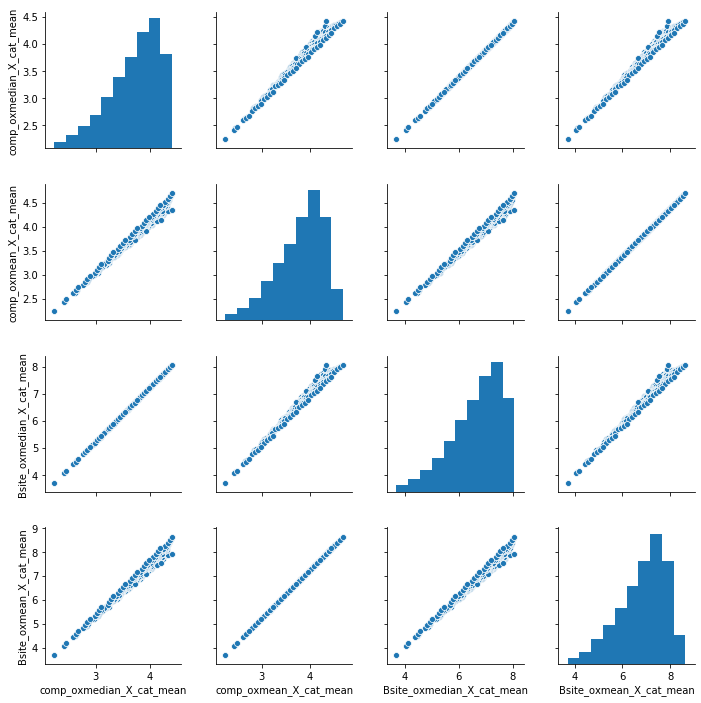

In [23]:
"Identify groups of highly correlated (r>0.99) features"
groups = get_linked_groups(ndf,thresh=0.99)
print('Identified {} groups of inter-correlated features'.format(len(groups)))

"Plot example correlation group"
sn.pairplot(ndf,vars=list(groups[7]))

In [24]:
"Zero-variance columns"
list(ndf.columns[ndf.var()==0])

['Bsite_TM_frac',
 'Bsite_donor_mag',
 'comp_num_atoms',
 'comp_donor_mag',
 'Bsite_valence_elec_s_mean',
 'Bsite_valence_elec_p_mean',
 'Bsite_valence_elec_f_mean',
 'Bsite_valence_elec_p_frac',
 'Bsite_valence_elec_f_frac',
 'Bsite_valence_unfilled_s_mean',
 'Bsite_valence_unfilled_s_std',
 'Bsite_valence_unfilled_p_mean',
 'Bsite_valence_unfilled_p_std',
 'Bsite_valence_unfilled_f_mean',
 'Bsite_valence_unfilled_f_std',
 'comp_valence_elec_s_mean',
 'comp_valence_elec_f_mean',
 'comp_valence_elec_f_frac',
 'comp_valence_unfilled_s_mean',
 'comp_valence_unfilled_s_std',
 'comp_valence_unfilled_f_mean',
 'comp_valence_unfilled_f_std']